In [1]:
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp
import random

In [4]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [5]:
from collections import namedtuple

In [6]:
%load_ext autoreload
%autoreload 2
import rethinking

In [7]:
from rethinking.data import RethinkingDataset
from rethinking.data import dataframe_to_tensors
from rethinking.mcmc import sample_posterior

In [8]:
# a function to plot the density using arviz plot_kde function
def plot_density(positions, x_label="Position", y_label="Density"):
    az.plot_kde(positions)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [9]:
plt.rcParams['figure.figsize'] = [6, 4]

In [10]:
# generate a key
# jax.random.key (new version of jax.random.PRNGKey) 
#   not working with tfp.substrates.jax.mcmc
def a_key():
    # return jax.random.key(random.randint(0, 1000_000))
    return jax.random.PRNGKey(random.randint(0, 1000_000))

In [11]:
# jnp array replaces tf array
# but jnp has yet no equivalant to tf.Variable() 
from tensorflow_probability.python.internal.backend import jax as tf

In [12]:
tf.Variable(3)

<NumpyVariable at 0x309260880 for ArrayImpl at 0x309b161d0>

## 4.1 Why normal distributions are normal

### 4.1.1 Normal by addition

##### Code 4.1

This snippet is showing the notion of "Normal distribution by Addition"

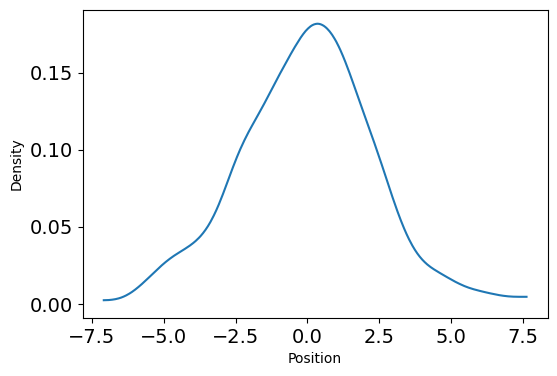

In [43]:
u1 = tfd.Uniform(low=-1.0, high=1.0)
pos = jnp.sum(u1.sample(sample_shape=(16, 1000), seed=a_key()), axis=0)
plot_density(pos)

### 4.1.2 Normal by multiplication

##### Code 4.2 & 4.3

This snippet is showing the notion of "Normal distribution by Multiplication"

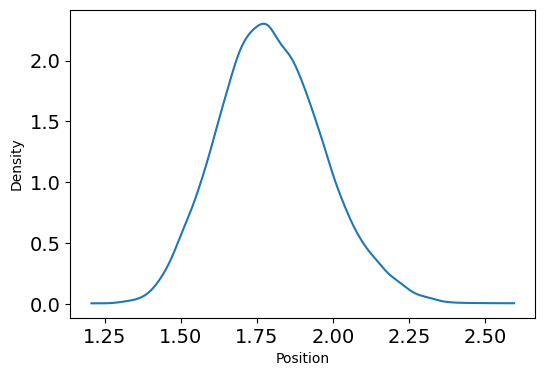

In [44]:
u2 = tfd.Uniform(low=1.0, high=1.1)
pos = jnp.prod(u2.sample(sample_shape=(12, 10000), seed=a_key()), axis=0)
plot_density(pos)

##### Code 4.4

Continuation of the notion of "Normal distribution by Multiplication"

Author explains that - "The smaller the effect of a variable (locus in the example), the better the additive approximation will be"

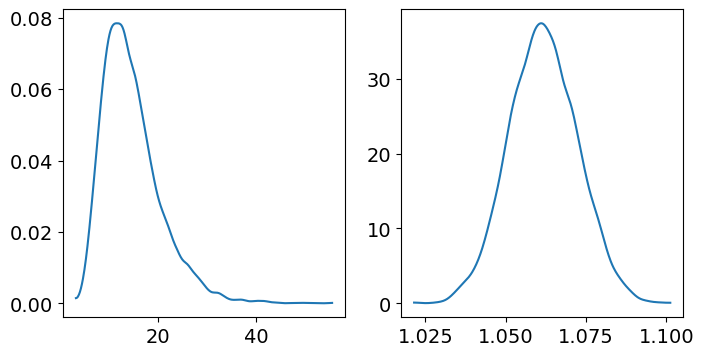

In [45]:
big = jnp.prod(tfd.Uniform(low=1.0, high=1.5).sample(sample_shape=(12, 10000), 
                                                     seed=a_key()), axis=0)
small = jnp.prod(tfd.Uniform(low=1.0, high=1.01).sample(sample_shape=(12, 10000), 
                                                        seed=a_key()), axis=0)

_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

### 4.1.3 Normal by log-multiplication

##### Code 4.5

This snippet is showing the notion of "Normal distribution by log-multiplication"

Author explains - "Large deviates that are multi- plied together do not produce Gaussian distributions, but they do tend to produce Gaussian distributions on the log scale. So even multiplicative interactions of large deviations can produce Gaussian distributions, once we measure the outcomes on the log scale."

In [46]:
log_big = jnp.log(
  jnp.prod(
    tfd.Uniform(low=1.0, high=1.5).sample(sample_shape=(12, 10000), 
                                          seed=a_key()), axis=0))

<Axes: >

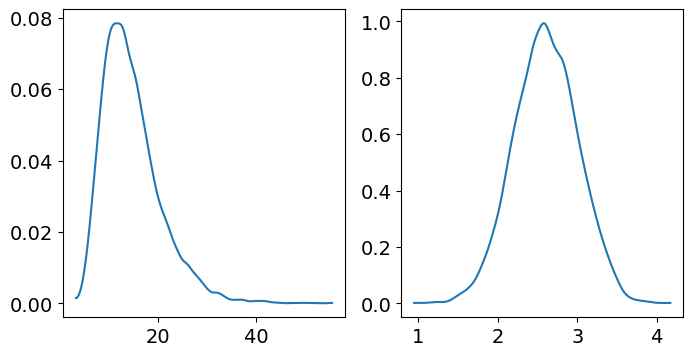

In [47]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(log_big, ax=ax[1])

## 4.2 A language for describing models

##### Code 4.6

Here the globe tossing model is described again.

$w$ = Observed count of water

$n$ = Total number of tosses

$p$ = Proportion of water on the globel


This is the first introduction/usage of Bayes' Theorem


Text(0, 0.5, 'Density')

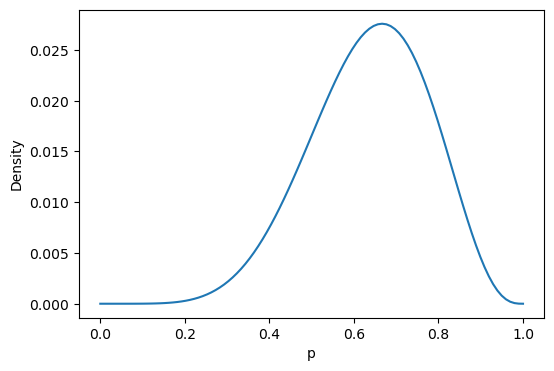

In [12]:
w, n = 6.0, 9.0

p_grid = jnp.linspace(0.0, 1.0, 100)

b1_dist = tfd.Binomial(total_count=n, probs=p_grid)
u3_dist = tfd.Uniform(low=0.0, high=1.0)

posterior = b1_dist.prob(w) * u3_dist.prob(p_grid)
posterior = posterior / jnp.sum(posterior)

plt.plot(p_grid, posterior)
plt.xlabel("p")
plt.ylabel("Density")

## 4.3 Gaussian model of height

### 4.3.1 The data

##### Code 4.7, 4.8 


We are now building the Gaussian model of height


In [13]:
d = RethinkingDataset.Howell1.get_dataset()
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


##### Code 4.9

In [14]:
az.summary(d.to_dict(orient="list"), kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
age,29.344,20.747,0.000,57.000
height,138.264,27.602,90.805,170.180
male,0.472,0.500,0.000,1.000
weight,35.611,14.719,11.368,55.707


##### Code 4.10

For now we are going to work only with the height columns so let's look at it

In [15]:
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

##### Code 4.11

We are only interested in the heights of adults only (for the time being; we will incorporate the whole dataset later)

In [16]:
d2 = d[d.age >= 18]

### 4.3.2 The model

##### Code 4.12 & 4.13

Author explains that whatever is your prior, it's a very good idea to always plot it. This way we will have a better
sense of our model.

Here we have assumed certain values for our priors and as per the instruction plotting them

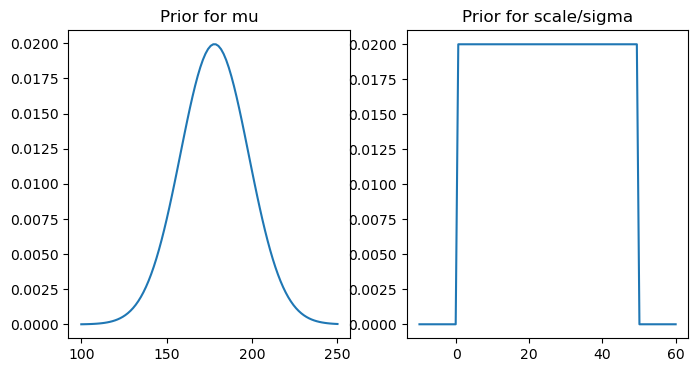

In [17]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

x = jnp.linspace(100.0, 250.0, 100)
mu_prior = tfd.Normal(loc=178.0, scale=20.0)
ax1.set_title("Prior for mu")
ax1.plot(x, mu_prior.prob(x))

x = jnp.linspace(-10.0, 60.0, 100)
scale_prior = tfd.Uniform(low=0.0, high=50.0)
ax2.set_title("Prior for scale/sigma")
ax2.plot(x, scale_prior.prob(x))

##### Code 4.14

In the above section we have chosen priors for $h$, $\mu$, $\sigma$ and even plotted them. It is also important to now see what kind of distribution these assumptions generate. This is called **PRIOR PREDICTIVE simulation** and is important part of modelling.

<Axes: >

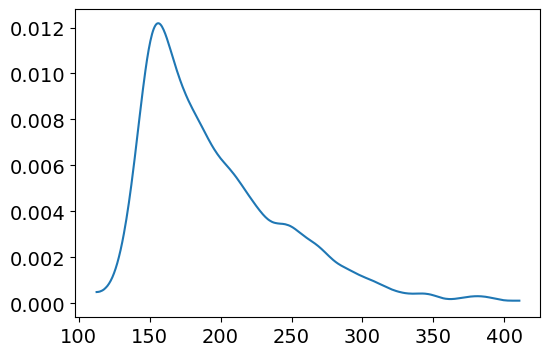

In [18]:
# plot the joint distribution of h, mu and sigma
n_samples = 1000

sample_mu = tfd.Normal(loc=178.0, scale=20.0).sample(n_samples, seed=a_key())
sample_sigma = tfd.Uniform(low=0.0, high=50.0).sample(n_samples, seed=a_key())
prior_h = tfd.Normal(loc=sample_mu, scale=sample_sigma).sample(seed=a_key())

az.plot_kde(prior_h)

##### Code 4.15

As mentioned in above cell the prior predictive simulation is helpful in assigning sensible priors. Here we see if we change the scale for *sample_mu* to 100 (instead of using 20 as in the above cell)

<Axes: >

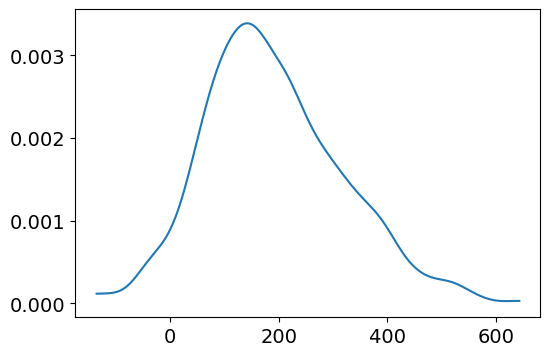

In [19]:
# plot the joint distribution of h, mu and sigma
n_samples = 1000

sample_mu = tfd.Normal(loc=178.0, scale=100.0).sample(n_samples, seed=a_key())
sample_sigma = tfd.Uniform(low=0.0, high=50.0).sample(n_samples, seed=a_key())
prior_h = tfd.Normal(loc=sample_mu, scale=sample_sigma).sample(seed=a_key())

az.plot_kde(prior_h)

Now, what the above plot is showing that there are about 4% of people that have a **negative height** and about 18% on the right side have height not common at all for humans to attain ! So clearly this choice of scale (i.e. 100) is not a good one as the prior. 

### 4.3.3 Grid approximation of the posterior distribution

##### Code 4.16

Here we are doing **Grid approximation of the posterior distribution**. A very crude technique that may work for small/simple models. It is customary to do it to make a point but later we will use well established inference methods based on MCMC and VI

In [20]:
def compute_likelihood(mu, sigma, sample_data):
    def _compute(mu, sigma, sample_data):
        norm_dist = tfd.Normal(loc=mu, scale=sigma)
        return jnp.sum(norm_dist.log_prob(sample_data))

    return jax.vmap(_compute, in_axes=(0, 0, None))(mu, sigma, sample_data)


def grid_approximation(sample_data, mu_start=150.0, mu_stop=160.0, 
                       sigma_start=7.0, sigma_stop=9.0):
    mu_list = jnp.linspace(start=mu_start, stop=mu_stop, num=200)
    sigma_list = jnp.linspace(start=sigma_start, stop=sigma_stop, num=200)

    mesh = jnp.meshgrid(mu_list, sigma_list)
    mu = jnp.reshape(mesh[0], -1)
    sigma = jnp.reshape(mesh[1], -1)

    log_likelihood = compute_likelihood(mu, sigma, sample_data)

    logprob_mu = tfd.Normal(178.0, 20.0).log_prob(mu)
    logprob_sigma = tfd.Uniform(low=0.0, high=50.0).log_prob(sigma)

    log_joint_prod = log_likelihood + logprob_mu + logprob_sigma
    joint_prob = jnp.exp(log_joint_prod - jnp.max(log_joint_prod))

    return mesh, joint_prob

In [21]:
mesh, joint_prob = grid_approximation(d2.height.values)

##### Code 4.17

Make a contour plot

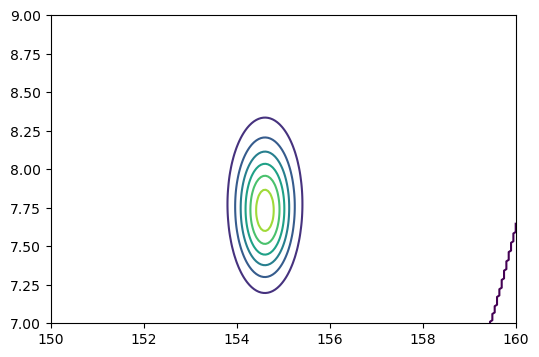

In [22]:
reshaped_joint_prob = jnp.reshape(joint_prob, (200, 200))
plt.contour(*mesh, reshaped_joint_prob)

##### Code 4.18

Here we are plotting a heatmap instead of contour plot

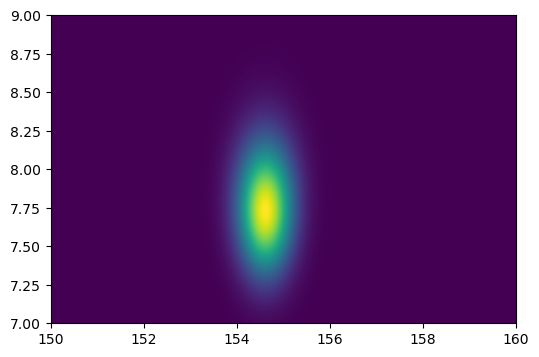

In [23]:
plt.imshow(reshaped_joint_prob, origin="lower", extent=(150, 160, 7, 9), aspect="auto")

### 4.3.4 Sampling from the posterior

##### Code 4.19 & 4.20

We are at point of now **Sampling from the Posterior**

In [24]:
joint_prob.shape, joint_prob[:10]

((40000,),
 Array([1.9548477e-35, 1.0217693e-34, 5.2462947e-34, 2.6442002e-33,
        1.3094891e-32, 6.3626665e-32, 3.0384244e-31, 1.4246412e-30,
        6.5601898e-30, 2.9649415e-29], dtype=float32))

In [25]:
# This is a trick to sample row numbers randomly with the help of Categorical distribution
sample_rows = tfd.Categorical(probs=(joint_prob / jnp.sum(joint_prob))).sample(
  100_00, seed=a_key())
sample_rows

Array([12692,  7886, 26306, ...,  2892, 16093, 18492], dtype=int32)

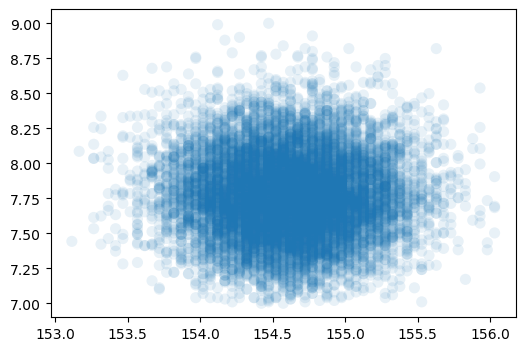

In [26]:
mu = mesh[0].reshape(-1)
sigma = mesh[1].reshape(-1)

# We are sampling 2 parameters here from the selected rows
sample_mu = mu[sample_rows]
sample_sigma = sigma[sample_rows]

plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none")

##### Code 4.21

Time to summarize/describe the distribution of confidence in each combination of $\mu$ & $\sigma$ using the samples.

[]

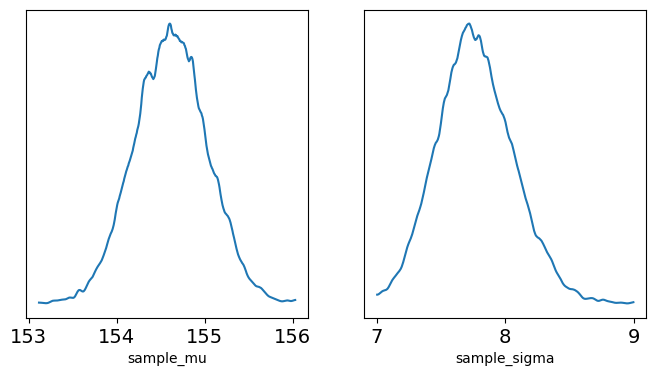

In [27]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel("sample_mu")
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([])

As should be clear from the plot, the densities here are very close *normal distribution*. As sample size increases, posterior densities show this behavior. 

Pay attention to sample_sigma, density of it has a **longer right-hand tail**. Author mentions here that this condition is very common for standard deviation parameters. No explanation about it at this point of time.

##### Code 4.22

Now we want to summarize the widths of these densities with **posterior compatibility intervals**

In [28]:
type(sample_mu), type(sample_mu.__array__()), type(jax.device_get(sample_mu))

(jaxlib.xla_extension.ArrayImpl, numpy.ndarray, numpy.ndarray)

### 4.3.5 Finding the posterior distribution using quap

### 4.3.5 Finding the posterior distribution using quap

In [29]:
print("sample_mu -", az.hdi(sample_mu.__array__()))
print("sample_sigma -", az.hdi(jax.device_get(sample_sigma)))

sample_mu - [153.86934 155.37689]
sample_sigma - [7.231156 8.336683]


##### Code 4.23 & Code 4.24

Author now wants to use Quadratic approximation but he wants to make a point about using it and impact of $\sigma$ on this approximation.

Here the above analysis of the height data is repeated but with only a fraction of original data. The reasoning behind is to demonstrate that, in principle, the posterior is not always Gaussian in shape.

Author explains that for a Guassian $\mu$ & Gaussian likelihood the shape is always Gaussian irrespective of the sample size but it is the $\sigma$ that causes problems.

In [30]:
# We just get 20 samples for now and repeat our exercise
d3 = d2.height.sample(n=20)

In [31]:
mesh2, joint_prob2 = grid_approximation(
    d3.values,
    mu_start=150.0,
    mu_stop=170.0,
    sigma_start=4.0,
    sigma_stop=20.0)

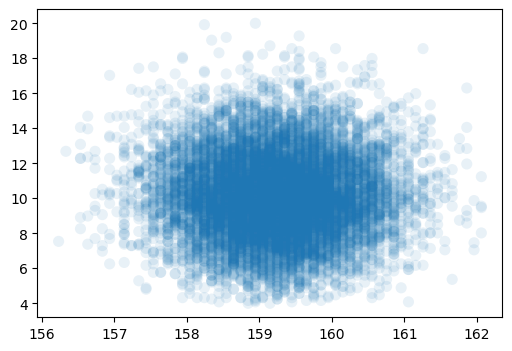

In [32]:
mu2 = mesh2[0].reshape(-1)
sigma2 = mesh2[1].reshape(-1)

# We are sampling 2 parameters here from the selected rows
sample_mu2 = mu2[sample_rows]
sample_sigma2 = sigma2[sample_rows]

plt.scatter(sample_mu2, sample_sigma2, s=64, alpha=0.1, edgecolor="none")

##### Code 4.25

[]

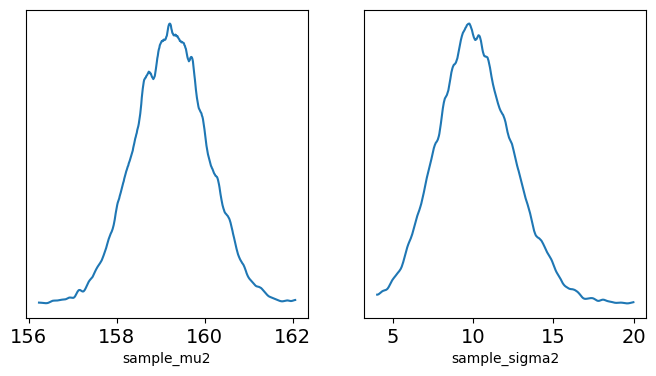

In [33]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu2, ax=ax[0])
ax[0].set_xlabel("sample_mu2")
ax[0].set_yticks([])
az.plot_kde(sample_sigma2, ax=ax[1])
ax[1].set_xlabel("sample_sigma2")
ax[1].set_yticks([])

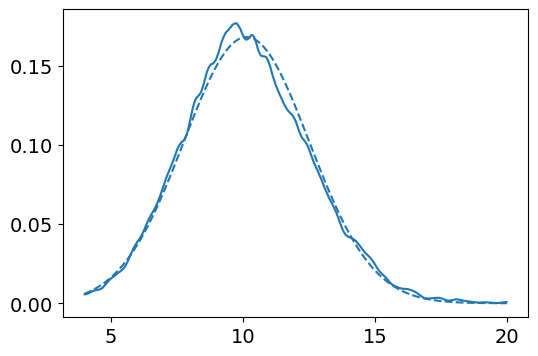

In [34]:
az.plot_kde(sample_sigma2)
x = jnp.sort(sample_sigma2)
plt.plot(x, tfd.Normal(loc=jnp.mean(x), scale=jnp.std(x)).prob(x), "--")

### 4.3.5 Finding the posterior distribution using quap

##### Code 4.26

We will reload our data frame and start to use quadratic approximiation now

In [13]:
d = RethinkingDataset.Howell1.get_dataset()
d2 = d[d.age > 18]

##### Code 4.27

We are now ready to define our model using tensorflow probability.


There are few ways to define a model using tfp, I am going to use a variant
of JointSequential that uses Coroutines (generator) based syntax. However, you can always
define as a plain function and return log probs yourself. An example of plain function that would be 

```python
def joint_log_prob_model(mu, sigma, data):
  mu_dist = tfd.Normal(loc=178., scale=20.)
  sigma_dist = tfd.Uniform(low=0., high=50.)
  height_dist = tfd.Normal(loc=mu, scale=sigma)
  
  return (
      mu_dist.log_prob(mu) +
      sigma_dist.log_prob(sigma) +           
      tf.reduce_sum(height_dist.log_prob(data)) 
  )
```

##### Code 4.28

In [14]:
n_sample = d2.shape[0]

# using JointDistributionNamedAutoBatched

In [15]:
m41 = dict(
    mu = tfd.Normal(loc=178.0, scale=20.0),
    sigma = tfd.Uniform(low=0.0, high=50.0),
    height = lambda mu, sigma: tfd.Sample(tfd.Normal(loc=mu, scale=sigma), n_sample)
)

jd_4_1_N = tfd.JointDistributionNamedAutoBatched(m41)

In [16]:
jd_4_1_N.sample(seed=a_key())

{'sigma': Array(3.4454525, dtype=float32),
 'mu': Array(141.10692, dtype=float32),
 'height': Array([136.2867 , 142.81631, 144.52559, 143.01927, 140.19974, 143.61244,
        139.19661, 141.02632, 144.7987 , 140.92413, 139.59096, 141.31204,
        141.53468, 144.3814 , 145.09534, 136.68048, 139.50357, 143.57225,
        143.74974, 139.63046, 144.72708, 145.4952 , 139.90067, 139.29202,
        141.34213, 139.91287, 138.87463, 144.35286, 140.43495, 144.66426,
        142.40079, 141.30919, 145.03917, 143.2085 , 146.18774, 147.27148,
        139.91533, 141.61687, 140.30322, 138.47522, 141.40398, 149.0303 ,
        146.39737, 141.23398, 143.64508, 148.88016, 144.71255, 141.0257 ,
        137.94073, 143.50443, 138.27785, 146.91129, 149.75958, 145.47925,
        137.99066, 142.05945, 140.53381, 138.47964, 147.57481, 142.27547,
        138.3288 , 143.47389, 137.65651, 141.4764 , 139.81343, 140.53258,
        145.81306, 147.0485 , 144.80142, 142.14354, 140.6121 , 146.8649 ,
        144.00081, 

In [17]:
# sample of 'Named': dictionary
type(jd_4_1_N.sample(seed=a_key()))

dict

In [20]:
# mcmc.sample_chain(current_state): Tensor or Python list of Tensor
#  - error for dict input 
# a list of two jnp.array
init_state = [jd_4_1_N.sample(seed=a_key())[s] for s in ["mu", "sigma"]]
init_state

[Array(169.92018, dtype=float32), Array(18.514395, dtype=float32)]

In [21]:
# Match the function args with the init_state
# init_state(a list of two jnp.array) be interpreted as "mu" and "sigma"
def target_log_prob(mu, sigma):
    # sample of 'Named': dictionary
    samples = {"mu": mu, "sigma": sigma, "height": jnp.array(d2["height"])}
    return jd_4_1_N.log_prob(samples)

In [31]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    step_size=0.2, 
    num_leapfrog_steps=2)

In [32]:
states = tfp.mcmc.sample_chain(
    1000,
    current_state=init_state,
    kernel=kernel,
    num_burnin_steps=200,
    trace_fn=None,
    seed=a_key())

In [33]:
states

[Array([153.79872, 154.09315, 153.86946, 153.86946, 154.17657, 154.51218,
        154.8484 , 155.49089, 155.49089, 155.60121, 154.70827, 155.18669,
        155.59431, 154.60294, 154.56126, 154.56667, 154.72224, 155.0054 ,
        155.2941 , 154.59122, 154.0716 , 154.34601, 154.44832, 154.39824,
        154.71559, 154.84637, 154.57631, 154.53534, 155.1098 , 154.25504,
        153.94464, 154.48163, 154.7406 , 154.78784, 154.15659, 154.11734,
        154.11734, 155.26195, 155.27834, 154.9041 , 154.49944, 154.61943,
        154.4496 , 153.95213, 154.14453, 154.47385, 154.0009 , 154.80057,
        154.8172 , 154.8172 , 155.05647, 154.5848 , 154.50941, 154.21985,
        154.01508, 154.28122, 154.57298, 154.4625 , 154.27458, 154.75371,
        153.65248, 154.19023, 153.55412, 154.26204, 154.28685, 154.42676,
        153.91365, 153.84738, 154.20914, 154.20914, 154.20914, 154.20615,
        153.91737, 153.74818, 153.79465, 153.65038, 154.02304, 154.48737,
        154.48737, 154.04881, 154.7220

In [34]:
ss = dict(zip(["mu", "sigma"], [jax.device_get(s) for s in states]))

In [35]:
az.summary(ss, round_to=2, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.67,0.44,154.09,155.49
sigma,7.79,0.29,7.33,8.24


In [41]:
# shape of mcmc.sample_chain output depends on shape of init_state
init_state = jnp.concatenate(
  [jnp.expand_dims(s, axis=0) for s in init_state if jnp.ndim(s)==0])
# an jnp.array of two elements
init_state

Array([169.92018 ,  18.514395], dtype=float32)

In [43]:
# def target_log_prob(mu, sigma):
def target_log_prob(params):
    mu, sigma = params
    params = {"mu": mu, "sigma": sigma, "height": jnp.array(d2["height"])}
    return jd_4_1_N.log_prob(params)

In [44]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    step_size=0.2, 
    num_leapfrog_steps=2)

In [45]:
states = tfp.mcmc.sample_chain(
    1000,
    current_state=init_state,
    kernel=kernel,
    num_burnin_steps=200,
    trace_fn=None,
    seed=a_key())

In [48]:
states

Array([[154.97331  ,   8.37017  ],
       [154.91084  ,   7.879549 ],
       [154.62492  ,   7.8711834],
       ...,
       [154.54643  ,   7.9651084],
       [154.87134  ,   8.189929 ],
       [154.87134  ,   8.189929 ]], dtype=float32)

# using JointDistributionCoroutineAutoBatched

In [ ]:
def m41c():
    mu = yield tfd.Normal(loc=178.0, scale=20.0, name="mu")
    sigma = yield tfd.Uniform(low=0.0, high=50.0, name="sigma")
    height = yield tfd.Sample(tfd.Normal(loc=mu, scale=sigma, name="height"), n_sample)

jdc_4_1_C = tfd.JointDistributionCoroutineAutoBatched(m41)

In [158]:
# 'Couroutine' sample: StructTuple
jdc_4_1.sample(seed=a_key())

StructTuple(
  mu=Array(144.399, dtype=float32),
  sigma=Array(33.16188, dtype=float32),
  height=Array(105.461395, dtype=float32)
)

In [268]:
init_state = jdc_4_1.sample(seed=a_key())

In [273]:
init_state = init_state[:-1]

In [283]:
def target_log_prob(mu, sigma):
    return jdc_4_1.log_prob(mu=mu, sigma=sigma, height=jnp.array(d2["height"]))

In [284]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    step_size=0.1, 
    num_leapfrog_steps=2
)

In [285]:
states = tfp.mcmc.sample_chain(
    1000,
    current_state=init_state,
    kernel=kernel,
    num_burnin_steps=300,
    trace_fn=None,
    seed=a_key()
)

TypeError: body_fun output and input must have identical types, got
['ShapedArray(int32[])', 'ShapedArray(uint32[2])', StructTuple(
  mu='DIFFERENT ShapedArray(float32[346]) vs. ShapedArray(float32[])',
  sigma='DIFFERENT ShapedArray(float32[346]) vs. ShapedArray(float32[])'
), MetropolisHastingsKernelResults(
  accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(
      log_acceptance_correction='ShapedArray(float32[346])',
      target_log_prob='ShapedArray(float32[346])',
      grads_target_log_prob=['DIFFERENT ShapedArray(float32[346]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float32[346]) vs. ShapedArray(float32[])'],
      initial_momentum=['DIFFERENT ShapedArray(float32[346]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float32[346]) vs. ShapedArray(float32[])'],
      final_momentum=['DIFFERENT ShapedArray(float32[346]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float32[346]) vs. ShapedArray(float32[])'],
      step_size=[],
      num_leapfrog_steps=[],
      seed=[]
    ),
  is_accepted='ShapedArray(bool[346])',
  log_accept_ratio='ShapedArray(float32[346])',
  proposed_state=StructTuple(
      mu='ShapedArray(float32[])',
      sigma='ShapedArray(float32[])'
    ),
  proposed_results=UncalibratedHamiltonianMonteCarloKernelResults(
      log_acceptance_correction='DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float32[346])',
      target_log_prob='ShapedArray(float32[346])',
      grads_target_log_prob=['ShapedArray(float32[])', 'ShapedArray(float32[])'],
      initial_momentum=['ShapedArray(float32[])', 'ShapedArray(float32[])'],
      final_momentum=['ShapedArray(float32[])', 'ShapedArray(float32[])'],
      step_size=[],
      num_leapfrog_steps=[],
      seed='ShapedArray(uint32[2])'
    ),
  extra=[],
  seed='ShapedArray(uint32[2])'
)].

In [208]:
# 'jit' version
def run_chain(init_state, seed):
    target_log_prob = jdc_4_1.log_prob
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob,
        step_size=0.01, 
        num_leapfrog_steps=2
    )
    return tfp.mcmc.sample_chain(
        1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=300,
        trace_fn=None,
        seed=seed
    )

states = jax.jit(run_chain)(jdc_4_1.sample(seed=a_key()), a_key())

In [199]:
type(states)

tensorflow_probability.substrates.jax.internal.structural_tuple.structtuple.<locals>.StructTuple

In [166]:
jax.tree.map(lambda x: x.shape, states)

StructTuple(
  mu=(1000,),
  sigma=(1000,),
  height=(1000,)
)

In [209]:
# convert StructTuple to OderedDict, to use arviz
states_dict = jax.tree.map(lambda x: jax.device_get(x), states)._asdict()
type(states_dict)

collections.OrderedDict

In [210]:
az.summary(states_dict, round_to=2, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
height,138.83,0.31,138.41,139.21
mu,138.59,0.34,138.16,139.16
sigma,0.48,0.11,0.33,0.69
